# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize
from datetime import date, timedelta
import datetime as dt
from dateutil.relativedelta import relativedelta
import time

# Volatility & Stock Paths

In [2]:
def time_splits(T, n):

    def calculate_expiry(T):
        today = date.today()
        days = T * 365.25  # Approximate days for given T years
        months = int(days // 30.4375)  # Approximate number of months (average month length)
        remaining_days = int(days - months * 30.4375)  # Remaining days after converting to months
        expiry = today + relativedelta(months=+months, days=+remaining_days)
        return expiry

    # Calculate expiry date based on T years
    today = date.today()
    expiry = calculate_expiry(T)

    # Generate n evenly spaced time points in years between today and expiry
    times = [i * T / (n - 1) for i in range(n)]  # Time points in years from 0 to T
    dates = [today + timedelta(days=int(time * 365.25)) for time in times]  # Convert to dates

    return {'times': times, 'dates': dates}

The function below returns the volatility and stock paths.

In [5]:
def volatility_and_stock_paths(S0, r, q, kappa, theta, v0, eps, corr, n, N, T):

  times = time_splits(T,n)['times']

  V = []
  S = []

  for j in range(N):
      rng = np.random.default_rng()
      mean = [0, 0]
      cov = [[1, corr], [corr, 1]]
      samples = rng.multivariate_normal(mean, cov, size=n, method='cholesky')

      v = [v0]  # list to store volatility values
      s = [S0]
      for i in range(1, n):
          delta_t = times[i] - times[i - 1]
          assert delta_t >= 0.00001, print(f'{delta_t} is negative')

          #n components of volatility path for 1 simulation
          vi = v[i - 1] + kappa * (theta - v[i - 1]) * delta_t + eps * np.sqrt(v[i - 1] * delta_t) * samples[i, 1]
          assert v[i - 1] * delta_t >= 0, print(v[i - 1] * delta_t)
          vi_max = max(vi, 0)
          v.append(vi_max)

          #n components of stock path for 1 simulation
          Si = s[i - 1]*np.exp((r - q - v[i - 1]/2)*delta_t + np.sqrt(v[i - 1]*delta_t)*samples[i, 0]) #make sure to add dividend yield here
          Si_max = max(Si,0)
          s.append(Si_max)
      V.append(v)
      S.append(s)

  return {'volatility paths': V, 'stock paths': S, 'Time (years)': times}

# Visualization of Paths

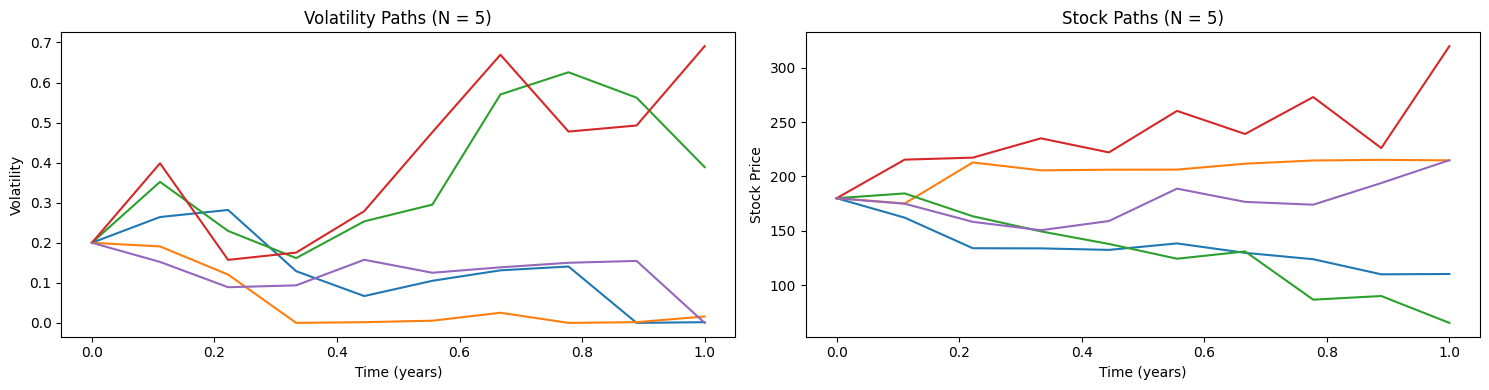

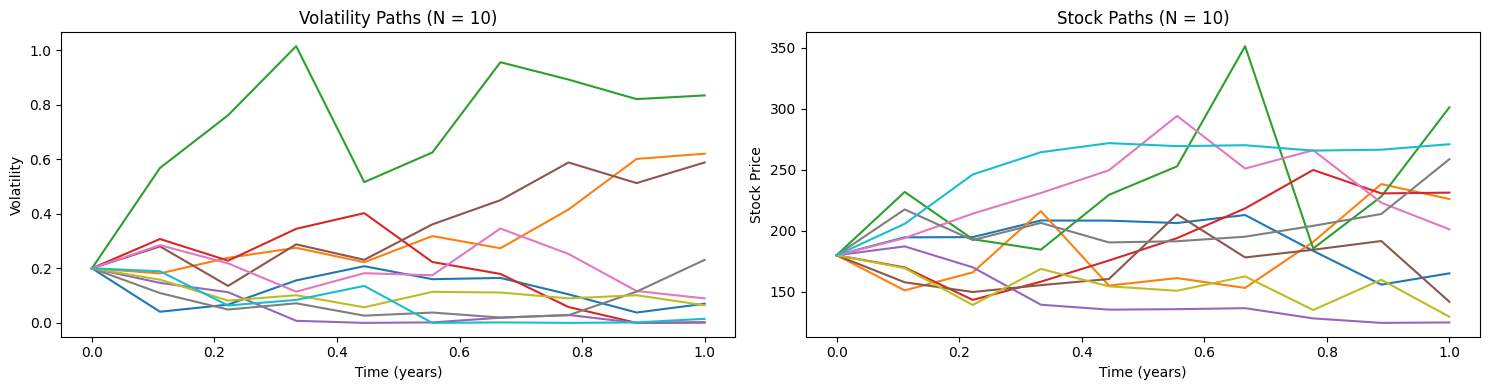

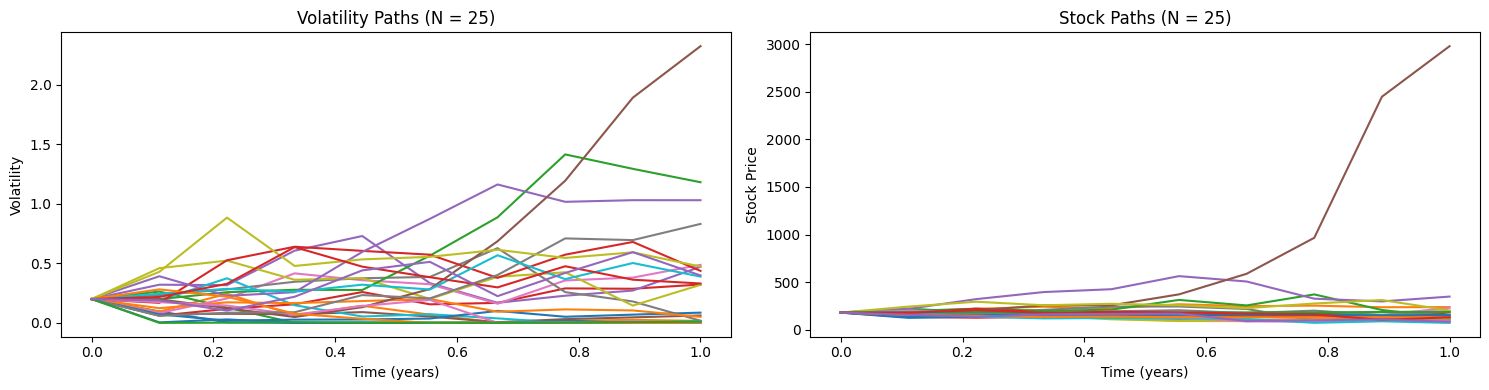

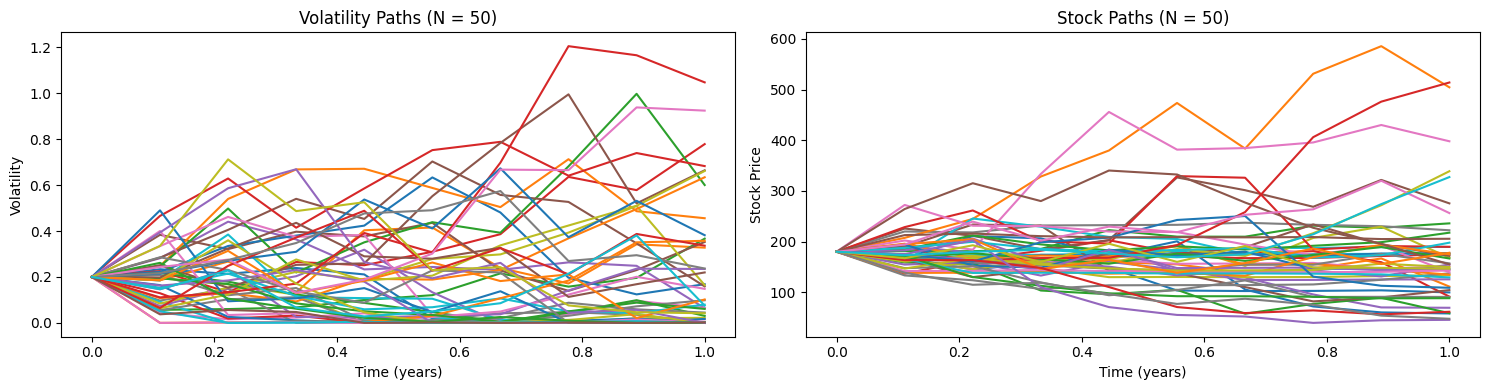

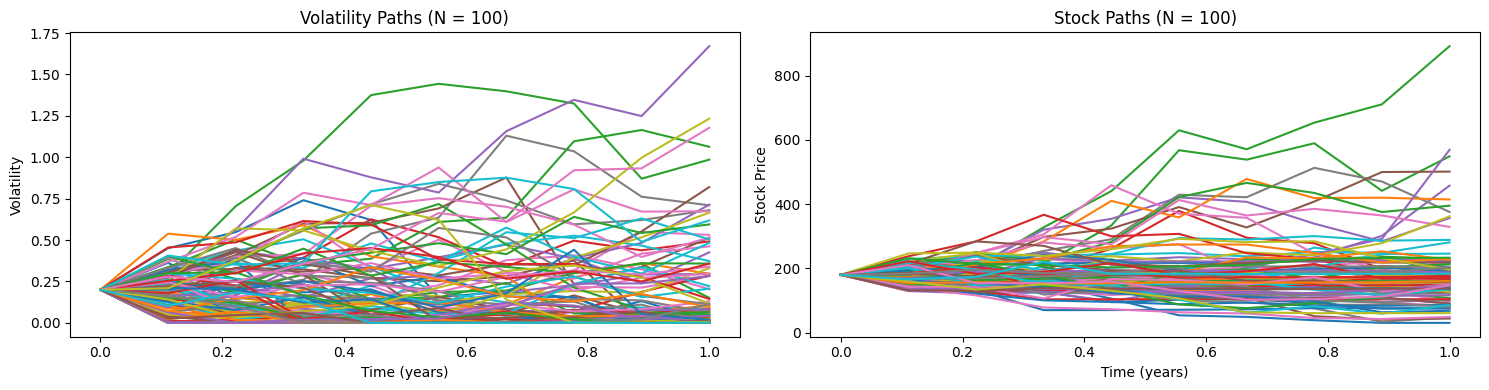

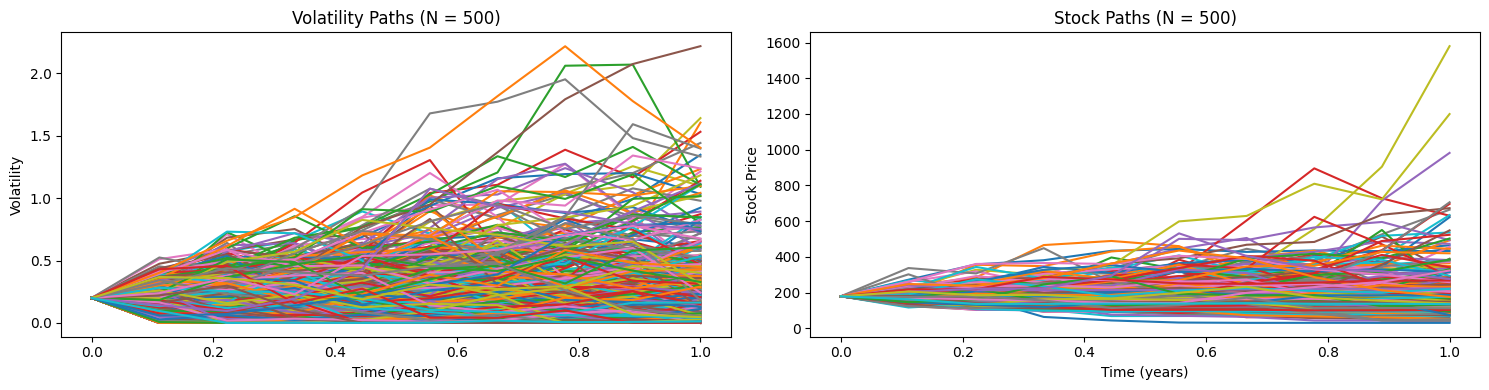

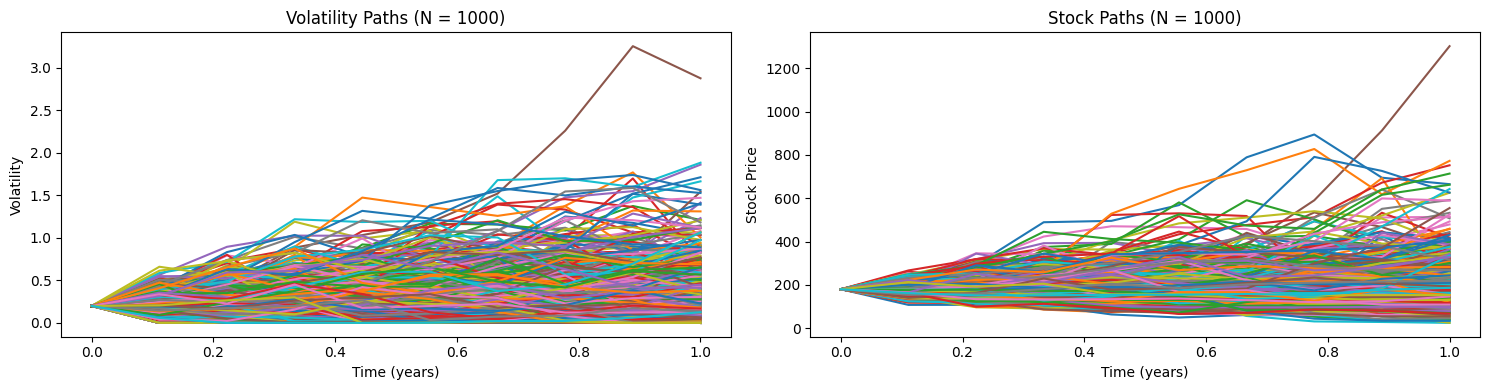

In [8]:
# Parameters
S0 = 180  # Initial stock price
r = 0.04  # Risk-free rate
q = 0.015 # Dividend yield
kappa = 0.08  # Mean reversion speed
theta = 0.20  # Long-term volatility
v0 = 0.20  # Initial volatility
eps = 0.80  # Volatility of volatility
corr = 0.4  # Correlation between stock and volatility
T = 1 #number of years
n = 10  # Number of time steps (within T years)
N_values = [5, 10, 25, 50, 100, 500, 1000] #Number of simulations, will iterate through each.

for N in N_values:

    result = volatility_and_stock_paths(S0, r, q, kappa, theta, v0, eps, corr, n, N, T)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)

    for path in result['volatility paths']:
        plt.plot(result['Time (years)'], path)
    plt.title(f'Volatility Paths (N = {N})')
    plt.xlabel('Time (years)')
    plt.ylabel('Volatility')

    plt.subplot(1, 2, 2)
    for path in result['stock paths']:
        plt.plot(result['Time (years)'], path)
    plt.title(f'Stock Paths (N = {N})')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')

    plt.tight_layout()
    plt.show()


# European Call Option - Heston Model

## Set Parameters

In [9]:
# Heston model parameters
# kappa: mean reversion rate for v(t)
# theta: long-run average of v(t)
# v0: initial squared volatility
# eps: volatility of volatility
# corr: correlation between the standard GM underlying S(t) and v(t)
kappa, theta, v0, eps, corr = 0.8, 0.20, 0.10, 0.80, -0.1

# Monte Carlo parameters
# n: number of time steps
# N: number of simulation paths
n, N = 10, 100000

# European call option parameters
# Strike ranges from 150, 155, ..., 210
S0, T, r, q = 180, 1/12, 0.04, 0.015
strikes = [i for i in range(150, 215, 5)]

## Monte Carlo Derivative Pricing w/ Heston Model

Pricing a European call option using the Heston model.

In [11]:
data = volatility_and_stock_paths(S0, r, q, kappa, theta, v0, eps, corr, n, N, T)

Warning! Running below takes a long time as it is simulating N = 100 thousand paths for the volatility and stock and is not necessary to visualize in pricing.

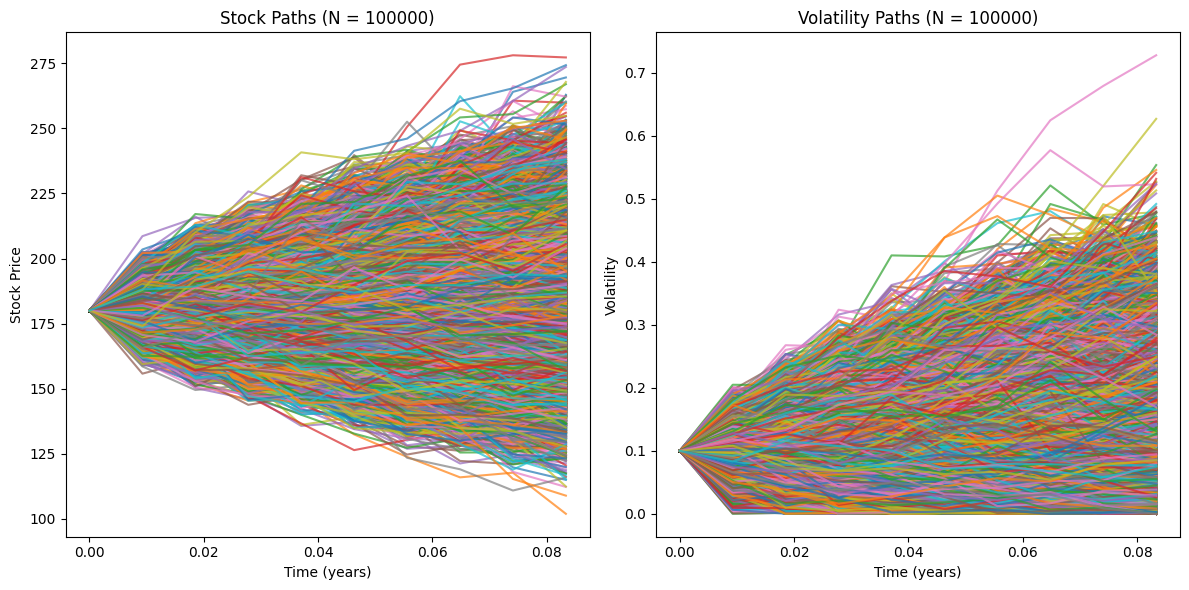

In [12]:
stock_paths = np.array(data['stock paths'])
vol_paths = np.array(data['volatility paths'])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(data['Time (years)'], stock_paths.T, alpha=0.7)  # Transpose to plot each path in a single call
axs[1].plot(data['Time (years)'], vol_paths.T, alpha=0.7)  # Same for volatility

axs[0].set_xlabel('Time (years)')
axs[0].set_ylabel('Stock Price')
axs[0].set_title(f'Stock Paths (N = {N})')

axs[1].set_xlabel('Time (years)')
axs[1].set_ylabel('Volatility')
axs[1].set_title(f'Volatility Paths (N = {N})')

plt.tight_layout()
plt.show()


Now we want to verify the distribution of the stock price at maturity T.  The distribution of the stock price is log normal which appears as normal in this situation due to large mean and low variance.  If we were to adjust the spot closer towards 0 then we would see a more "typical" log normal distribution.

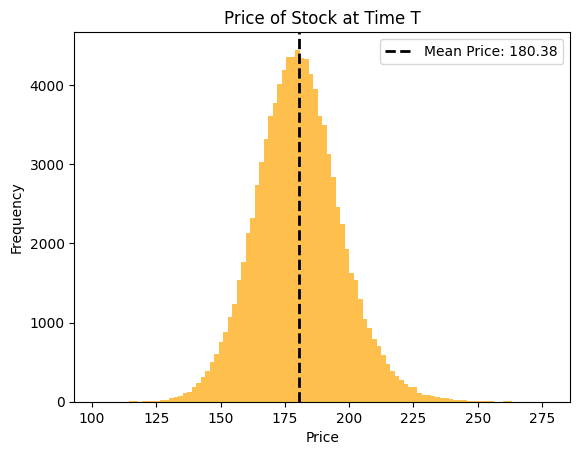

In [14]:
ST = [data['stock paths'][i][-1] for i in range(len(data['stock paths']))]
mean_price = np.mean(ST)
plt.hist(ST, bins=100, color='orange', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price of Stock at Time T')
plt.axvline(x=mean_price, color='black', linestyle='--', linewidth=2, label=f'Mean Price: {mean_price:.2f}')
plt.legend();

Similarly we want to inspect the distribution of the volatility price at maturity T.  There appears to be significant skew which makes sense since the volatility paths are simulated using a standard bivariate normal random variable and they cannot be negative.

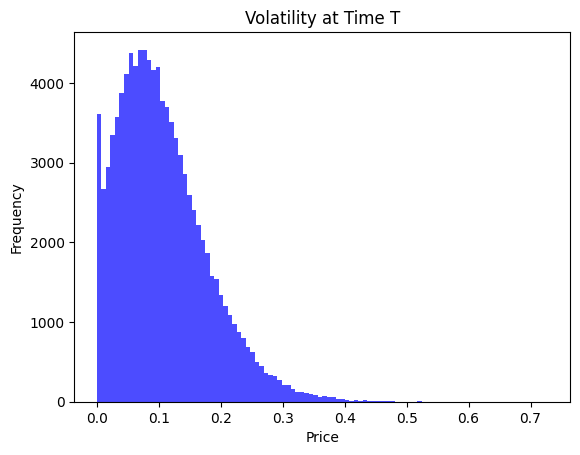

In [15]:
volT = [data['volatility paths'][i][-1] for i in range(len(data['volatility paths']))]
plt.hist(volT, bins=100, color='blue', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Volatility at Time T');

Now to calculate the option price by taking the payoff and discounting for each simulation, then taking the mean of all N simulations (to reduce variance).

In [19]:
def call_option_price_heston(S0, T, r, q, K, kappa=None, theta=None, v0=None, eps=None, corr=None, n=None, N=None):

    """Ensure missing parameters have default values"""
    kappa = kappa if kappa is not None else 0.8    # Default kappa
    theta = theta if theta is not None else 0.20   # Default theta
    v0 = v0 if v0 is not None else 0.10            # Default v0
    eps = eps if eps is not None else 0.80         # Default eps
    corr = corr if corr is not None else -0.1      # Default corr
    n = n if n is not None else 10                 # Default n (number of time steps)
    N = N if N is not None else 100000             # Default N (number of simulations)

    data = volatility_and_stock_paths(S0, r, q, kappa, theta, v0, eps, corr, n, N, T)
    ST = np.array([data['stock paths'][i][-1] for i in range(len(data['stock paths']))])
    disc_payoffs = np.exp(-r*T) * np.maximum(ST - K, 0.0)
    sim_price = np.mean(disc_payoffs)
    return sim_price


Let us run each option price for each strike 5 times.  This should be computationally expensive.

!!! Warning runtime is very long !!!

In [24]:
start_time = time.time()

heston_prices_ladder = {k:[] for k in strikes}
for i in range(5):
  for k in strikes:
    heston_prices_ladder[k].append(call_option_price_heston(S0, T, r, q, k))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.4f} seconds")

Execution time: 843.9862 seconds


In [59]:
df_multiple_sims = pd.DataFrame(heston_prices_ladder).T.reset_index()
df_multiple_sims = df_multiple_sims.rename(columns = {'index':'Strikes', 0:'Price 1', 1:'Price 2', 2:'Price 3', 3:'Price 4', 4:'Price 5'})
df_multiple_sims['Average Price'] = df_multiple_sims.loc[:,'Price 1':].mean(axis = 1)
df_multiple_sims

,Strikes,Price 1,Price 2,Price 3,Price 4,Price 5,Average Price
0,150,30.556009,30.483516,30.377864,30.488231,30.413379,30.463800
1,155,25.669349,25.686459,25.798694,25.777848,25.664349,25.719340
2,160,21.129290,21.061394,21.215645,21.102733,21.042900,21.110392
3,165,16.835869,16.832140,16.855340,16.850429,16.860159,16.846787
4,170,12.900140,12.953953,12.820376,12.933802,12.931655,12.907985
5,175,9.544039,9.496654,9.500434,9.543651,9.505544,9.518065
6,180,6.743202,6.701153,6.733437,6.681466,6.702743,6.712400
7,185,4.589503,4.510149,4.554410,4.580619,4.571100,4.561156
8,190,2.951238,2.922210,2.941494,2.928618,2.926714,2.934055
9,195,1.845980,1.851654,1.864155,1.845946,1.839476,1.849442


# Implied Volatility & Volatility Smile

Now, clearly the computational costs pose an issue.  Therefore, assume that 1 simulation is enough, and assume our Heston model estimate is the marekt price for the European call option.  Let us calculate the implied volatility assuming this price is the BSM price on the market.

In [60]:
def BSM_call_price(S0, T, r, q, K, v):
  d1 = (np.log(S0/K) + (r - q + v**2 /2)*T) / (v*np.sqrt(T))
  d2 = d1 - v*np.sqrt(T)
  price = S0*np.exp(-q*T)*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)
  return price

In [61]:
df_optimization = df_multiple_sims.iloc[:,:-1]
df_optimization['Lower Bound'] = [BSM_call_price(S0, T, r, q, k, 10**-5) for k in strikes]
for i, price in enumerate(list(df_optimization.columns)[1:6]):
  df_optimization[f'Convergence {i+1}'] = (df_optimization[str(price)] - df_optimization['Lower Bound']).apply(lambda x: True if x>=0 else False)

df_optimization['Convergence'] = df_optimization.iloc[:,7:].all(axis = 1)
df_optimization = df_optimization.drop(columns = df_optimization.iloc[:,7:-1].columns)
df_optimization

,Strikes,Price 1,Price 2,Price 3,Price 4,Price 5,Lower Bound,Convergence
0,150,30.556009,30.483516,30.377864,30.488231,30.413379,30.274308,True
1,155,25.669349,25.686459,25.798694,25.777848,25.664349,25.290947,True
2,160,21.129290,21.061394,21.215645,21.102733,21.042900,20.307586,True
3,165,16.835869,16.832140,16.855340,16.850429,16.860159,15.324225,True
4,170,12.900140,12.953953,12.820376,12.933802,12.931655,10.340864,True
5,175,9.544039,9.496654,9.500434,9.543651,9.505544,5.357503,True
6,180,6.743202,6.701153,6.733437,6.681466,6.702743,0.374142,True
7,185,4.589503,4.510149,4.554410,4.580619,4.571100,0.000000,True
8,190,2.951238,2.922210,2.941494,2.928618,2.926714,0.000000,True
9,195,1.845980,1.851654,1.864155,1.845946,1.839476,0.000000,True


In [62]:
def implied_volatility(S0, T, r, q, K, market_price):

    def objective(v):
        bsm_price = BSM_call_price(S0, T, r, q, K, v)
        return bsm_price - market_price

    return optimize.newton(objective, x0=0.3)

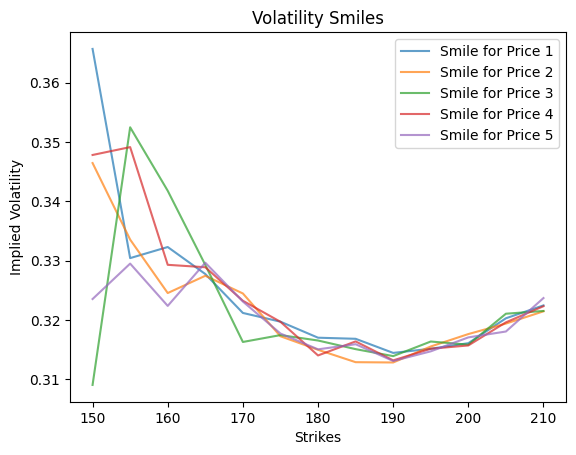

In [63]:
S0, T, r, q = 180, 1/12, 0.04, 0.015

labels = [f'Smile for Price {i}' for i in range(1,len(df_optimization.iloc[:,1:6].columns)+1)]

for price in list(df_optimization.iloc[:,1:6].columns):
  market_prices = list(df_optimization[price].values)
  implied_vols = {'Strike':[], 'Implied Volatility':[]}
  for k, market_price_k in zip(strikes,market_prices):
    imp_vol = implied_volatility(S0, T, r, q, k, market_price_k)
    implied_vols['Strike'].append(k)
    implied_vols['Implied Volatility'].append(imp_vol)

  plt.plot(implied_vols['Strike'], implied_vols['Implied Volatility'], alpha = 0.7)
  plt.xlabel('Strikes');
  plt.ylabel('Implied Volatility');
  plt.title('Volatility Smiles');
  plt.legend(labels)

Using Monte Carlo simulation for the Heston model rather than the semi-analytical solution leads to unusual behavior in your volatility smiles.

Monte Carlo Simulation Accuracy at the Wings:

*   Deep out-of-the-money (OTM) options at extreme strikes have very few paths that end up in-the-money
*   This means your payoff estimation becomes less reliable at the wings
*   The problem is especially acute for low strikes where you need many paths to capture rare large downward moves

Sample Size Limitations:



*   While 100,000 paths might seem large, for extreme strikes you might need many more paths
*   The variance of your estimator increases significantly at the wings
*   This explains why your smiles look unstable at the edges (particularly around strike 150)


To improve the results, I could:


*   Increase the number of paths (try 1,000,000 or more)
*   Use variance reduction techniques such as Antithetic sampling

For now, the valid volatility smiles are below:

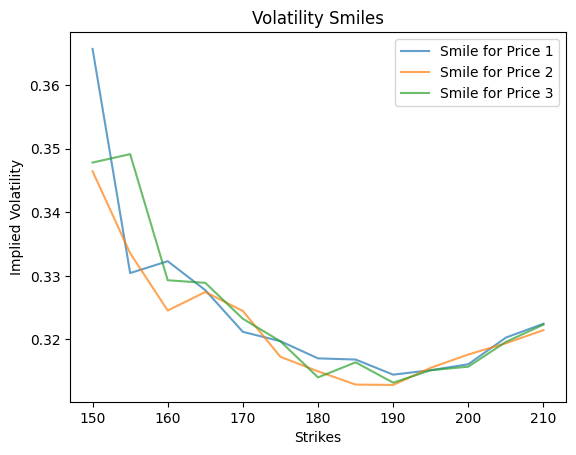

In [66]:
labels = [f'Smile for Price {i}' for i in range(1,len(df_optimization.iloc[:,1:6].columns)+1)]

for price in ['Price 1', 'Price 2', 'Price 4']:
  market_prices = list(df_optimization[price].values)
  implied_vols = {'Strike':[], 'Implied Volatility':[]}
  for k, market_price_k in zip(strikes,market_prices):
    imp_vol = implied_volatility(S0, T, r, q, k, market_price_k)
    implied_vols['Strike'].append(k)
    implied_vols['Implied Volatility'].append(imp_vol)

  plt.plot(implied_vols['Strike'], implied_vols['Implied Volatility'], alpha = 0.7)
  plt.xlabel('Strikes');
  plt.ylabel('Implied Volatility');
  plt.title('Volatility Smiles');
  plt.legend(labels)